# 12과 [예제] 시계열 데이터

## 1.환경준비

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as spst

In [21]:
data = pd.read_csv("https://raw.githubusercontent.com/DA4BAM/dataset/master/KOSPI.csv"
                   , usecols= ['Date', 'Close', 'Volume'])

data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Weekday'] = data['Date'].dt.weekday

data['Close_Lag'] = data['Close'].shift() # 전날 주가
data['Volume_Lag'] = data['Volume'].shift() # 전날 거래량
data.drop('Volume', axis = 1, inplace = True)

data.dropna(axis=0, inplace=True)

data.head()

,Date,Close,Volume,Year,Month,Weekday,Close_Lag,Volume_Lag
1,2014-10-01,1991.54,351581,2014,10,2,2020.09,322812.0
2,2014-10-02,1976.16,322656,2014,10,3,1991.54,351581.0
3,2014-10-06,1968.39,325078,2014,10,0,1976.16,322656.0
4,2014-10-07,1972.91,328234,2014,10,1,1968.39,325078.0
5,2014-10-08,1965.25,266180,2014,10,2,1972.91,328234.0


*  .shift() : 
    * 데이터를 한줄 내리기 
    * 시계열 데이터에 대해서 사용.
    * 만약 한 행이 일별 데이터라면, 전날 데이터를 붙이게 됨.

## 2.시계열 데이터란?

* 데이터셋
    * 일반 데이터셋 : 분석단위(행) 하나 하나가 개별 instance 입니다.
    * 시계열 데이터 : 데이터 분석 단위(행) 간에 (시간) 순서(sequence)가 있는 데이터

* 시계열 데이터 구분은, 비즈니스 이해단계에서 [문제정의]시 결정 됩니다. 
    * 해결해야 할 문제가 시간 순서 관점이 필요한지 아닌지. 


* KOSPI 2014.10 ~ 2019.09 데이터
    * Close : 코스피 종가(target)
    * Weekday : 요일 (0-월요일, 6-일요일)
    * Close_Lag : 전날 종가
    * Volume_Lag : 전날 거래량

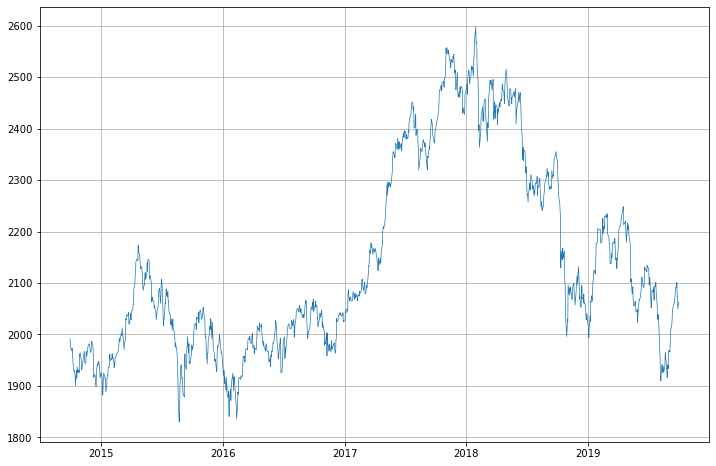

In [3]:
plt.figure(figsize = (12,8))
plt.plot('Date', 'Close', data = data, linewidth = .7)
plt.grid()
plt.show()

* 시계열 데이터는 시간(시기)을 고려해야 합니다.
    * 어느 기간? 
    * 반복되는 주기?


## 3.단변량

### 1) 숫자

* Close의 분포를 살펴보면…
    * 하나의 박스플롯으로 설명이 되나요?
    * 히스트그램을 보면 분포가 여러 개로 나뉘어 보입니다. 어떻게 해석해야 할까요?



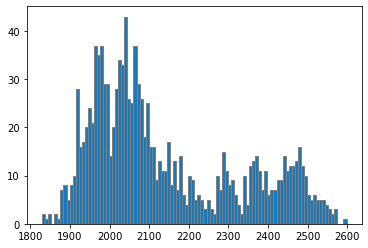

In [4]:
plt.hist(data['Close'], bins = 100, edgecolor = 'grey')
plt.show()

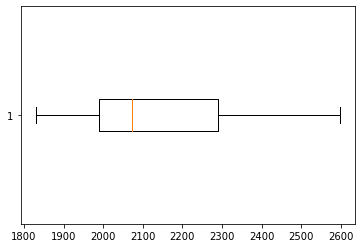

In [5]:
plt.boxplot(data['Close'], vert = False)
plt.show()

→ 분포가 2개 이상 섞여있는 그림을 boxplot으로 그리면 이상치가 안나오는 경향이 있다.

### 2) 범주

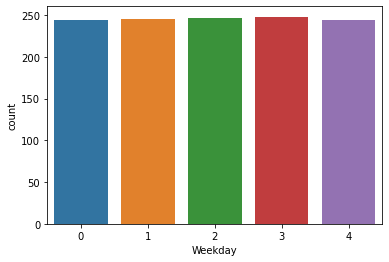

In [6]:
sns.countplot(x="Weekday", data=data)
plt.show()

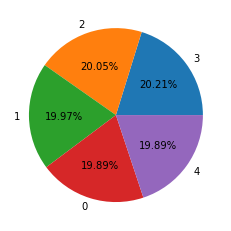

In [7]:
temp = data['Weekday'].value_counts()

plt.pie(temp.values, labels = temp.index, autopct='%.2f%%')
plt.show()

## 4.이변량

### 1) 숫자 vs 숫자

* 전날 종가와 오늘 종가를 비교해 보겠습니다.
    * 산점도 : 완전 직선
    * 상관분석 : 상관계수 거의 1, p-value 는 0!
    * 그러면 전날 종가만 있으면 다음날 코스피 지수 예측은 확실한가요?

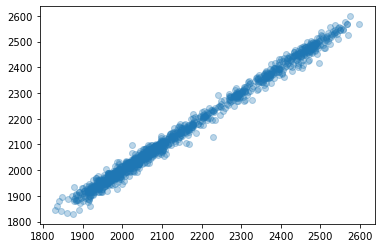

In [8]:
plt.scatter(data['Close_Lag'], data['Close'], alpha = .3)
plt.show()

In [9]:
# 상관계수와 p-value 
spst.pearsonr(data['Close_Lag'], data['Close'])

(0.9961042261752662, 0.0)

### 2) 범주 vs 숫자

* 요일별로 주가가 달라질까요?
    * 요일은 주가와 아무런 관련이 없어 보입니다.
    * 진짜 그럴까요?

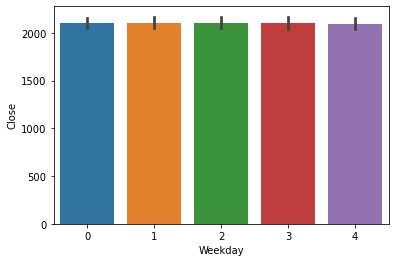

In [10]:
temp = data.loc[data.Date.between('2019-01-01','2019-01-31')]

sns.barplot(x="Weekday", y="Close", data = temp)
plt.show()

## 5.해결을 위한 아이디어

* 시계열 데이터를 smoothing 하여 그리기
    * .rolling(n).mean() : 이동평균 구하기

In [11]:
# 이동평균 변수 만들기 : 20일 이동평균
data['Close_MA'] = data['Close'].rolling(20).mean()

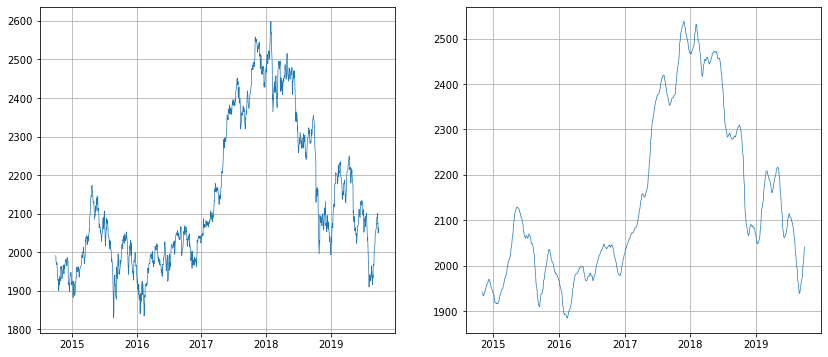

In [15]:
plt.figure(figsize = (14,6))
plt.subplot(1,2,1)
plt.plot('Date', 'Close', data = data, linewidth = .7)
plt.grid()

#  이동평균 구하기
plt.subplot(1,2,2)
plt.plot('Date', 'Close_MA', data = data, linewidth = .7)
plt.grid()
plt.show()

* 이전 데이터 대비 증감으로 분석하기

In [19]:
# 데이터 차분(difference) 데이터를 만들고 (전날대비 주가 증감)
data['diff'] = data['Close'] - data['Close_Lag']
print(data.tail())

           Date    Close  Year  Month  Weekday  Close_Lag  Volume_Lag  \
1223 2019-09-24  2101.04  2019      9        1    2091.70    420948.0   
1224 2019-09-25  2073.39  2019      9        2    2101.04    535771.0   
1225 2019-09-26  2074.52  2019      9        3    2073.39    651551.0   
1226 2019-09-27  2049.93  2019      9        4    2074.52    430577.0   
1227 2019-09-30  2063.05  2019      9        0    2049.93    285943.0   

       Close_MA   diff  
1223  2014.0605   9.34  
1224  2021.9145 -27.65  
1225  2029.4105   1.13  
1226  2034.8525 -24.59  
1227  2041.3345  13.12  


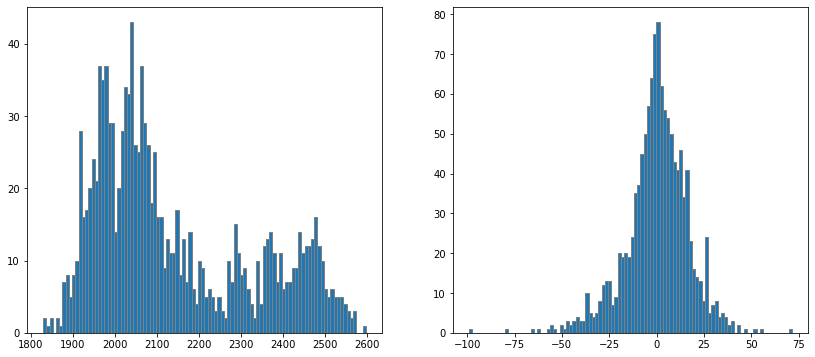

In [20]:
# 그래프를 그리면, 이전과 다른 새로운 관점의 그래프를 얻을 수 있습니다.

plt.figure(figsize = (14,6))
plt.subplot(1,2,1)
plt.hist(data['Close'], bins = 100, edgecolor = 'grey')

plt.subplot(1,2,2)
plt.hist(data['diff'], bins = 100, edgecolor = 'grey')
plt.show()


#### 실습

* 거래량에 대해서 전날 거래량과의 증감 변수를 하나 만드시오.
* 그래량에 대한 히스토그램과, 거래량 증가에 대한 히스토그램을 그려봅시다.

In [31]:
data = pd.read_csv("https://raw.githubusercontent.com/DA4BAM/dataset/master/KOSPI.csv"
                   , usecols= ['Date', 'Close', 'Volume'])

data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Weekday'] = data['Date'].dt.weekday

data['Close_Lag'] = data['Close'].shift() # 전날 주가
data['Volume_Lag'] = data['Volume'].shift() # 전날 거래량

data.dropna(axis=0, inplace=True)

data.head()

,Date,Close,Volume,Year,Month,Weekday,Close_Lag,Volume_Lag
1,2014-10-01,1991.54,351581,2014,10,2,2020.09,322812.0
2,2014-10-02,1976.16,322656,2014,10,3,1991.54,351581.0
3,2014-10-06,1968.39,325078,2014,10,0,1976.16,322656.0
4,2014-10-07,1972.91,328234,2014,10,1,1968.39,325078.0
5,2014-10-08,1965.25,266180,2014,10,2,1972.91,328234.0


In [32]:
# 증감에 대한 변수 만들기 #
data['vol_diff'] = data['Volume'] - data['Volume_Lag']

print(data.tail())

           Date    Close  Volume  Year  Month  Weekday  Close_Lag  Volume_Lag  \
1223 2019-09-24  2101.04  535771  2019      9        1    2091.70    420948.0   
1224 2019-09-25  2073.39  651551  2019      9        2    2101.04    535771.0   
1225 2019-09-26  2074.52  430577  2019      9        3    2073.39    651551.0   
1226 2019-09-27  2049.93  285943  2019      9        4    2074.52    430577.0   
1227 2019-09-30  2063.05  327625  2019      9        0    2049.93    285943.0   

      vol_diff  
1223  114823.0  
1224  115780.0  
1225 -220974.0  
1226 -144634.0  
1227   41682.0  


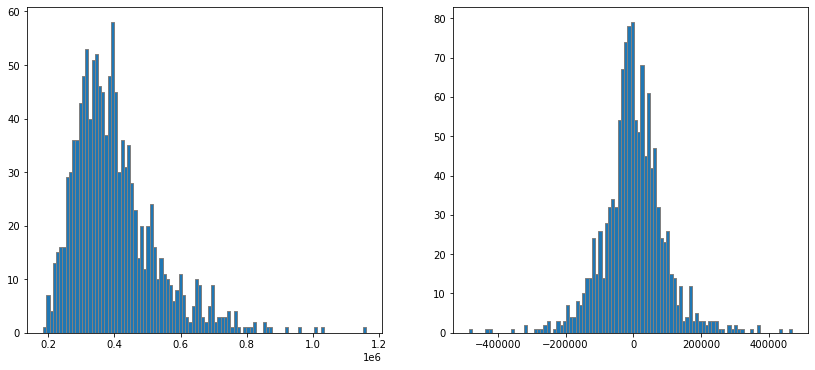

In [34]:
# 그래프를 그리면, 이전과 다른 새로운 관점의 그래프를 얻을 수 있습니다.

plt.figure(figsize = (14,6))
plt.subplot(1,2,1)
plt.hist(data['Volume'], bins = 100, edgecolor = 'grey')

plt.subplot(1,2,2)
plt.hist(data['vol_diff'], bins = 100, edgecolor = 'grey')

plt.show()